<center>
    <h1>Aerial Fire Detection with 
        Semantic Segmentation</h1>
    <h3>Samantha Schiefen</h3>
    <h4>sjs019@morningside.edu</h4>
</center>
---

This notebook uses the same structure as the notebook [*A Real-time Fire Segmentation Method Based on A Deep Learning Approach*](https://github.com/maidacundo/real-time-fire-segmentation-deep-learning/blob/main/Fire%20Segmentation%20Pipeline.ipynb) <a name="cite_notebook"></a> based on this paper[<sup>[1]</sup>](#note_paper).

This notebook uses the same method of loading and preprocessing the data, but uses it to compare different models for the task of fire segmentation.

The dataset used in the experiment is available at the following [link](https://ieee-dataport.org/open-access/flame-dataset-aerial-imagery-pile-burn-detection-using-drones-uavs).
In particular, the user should download the images of fires (*9) Images for fire segmentation (Train/Val/Test) Images.zip*) and the related masks (*10) Masks annotation for fire segmentation (Train/Val/Test) Masks.zip*) zip files in the section *"Dataset Files"* and copy them in the folder `./dataset`.

---
<small>

<a name="note_paper"></a>[1] Menga Li et al. “A Real-time Fire Segmentation Method Based on A Deep Learning Approach”. In: *IFAC-PapersOnLine*. 2022. url: https://www.sciencedirect.com/science/article/pii/S2405896322005055.

</small>


In [1]:
import numpy as np
import random
import cv2
import torch
from torch import cuda
import os
import re
from typing import Tuple
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from typing import Optional, Tuple, Union, Dict, List
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.nn.init as init
from torchinfo import summary
from numpy import save as np_save
from torch.utils.data.dataloader import Dataset, DataLoader
import torchvision.transforms as T
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.optim.optimizer import Optimizer
from time import time
from torchvision.transforms import Resize, InterpolationMode
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.cuda.get_device_name(0)
    print(f"Using GPU: {device}")
else:
    print("No GPU available, using CPU.")

Using GPU: Tesla P100-PCIE-16GB


In [3]:
# Settings for autoreloading.
%load_ext autoreload
%autoreload 2

In [4]:
# Settings for reproducibility.
def set_random_seed(random_seed: int = 42) -> None:
    """Set the random seed for reproducibility. The seed is set for the 
    random library, the numpy library and the OpenCV ansìd pytorch 
    libraries.
    
    Parameters
    ----------
    random_seed : int, optional
        The random seed to use for reproducibility, by default 42.
    """
    random.seed(random_seed)
    np.random.seed(random_seed)
    cv2.setRNGSeed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

SEED = 42
set_random_seed(SEED)

In [5]:
# Set the device on which the model operations are performed.
DEVICE = 'cuda' if cuda.is_available() else 'cpu'

In [6]:
BASE_DIR = '.'

# Data Preparation

In [7]:
ORIGINAL_SHAPE = (3840, 2160)
RESIZE_SHAPE = (512, 512)

## Data Extraction
In this section the images and masks data is extracted from the respective folders and resized from size $3840 \times 2160$ to the input shape of the network $512 \times 512$. Each image is a matrix of the given shape containing *3 channels* (B, G, R) presenting values within the interval $[0, 255]$. On the other hand, a mask is a matrix of the given size, containing values binary values ($0$ or $1$). The matrices representing the images and the masks are defined as: 
* images: $\mathbb{N}_{[0, 255]}^{512 \times 512 \times 3}$.

* masks: $\mathbb{N}_{[0, 1]}^{512 \times 512}$.

In particular, each image represent a frame of a aerial video taken by a drone, representing a fire in an outdoor area. The respective masks segment semantically the fire from the background.

Images and masks are represented as numpy arrays.

In [8]:
def load_images_from_folder(folder_path: str, resize_shape: Tuple[int, int], are_masks: bool) -> np.ndarray:
    """Load the images used for the segmentation task from a folder.
    If the `are_mask` parameter is set to true, the images will be
    decoded in grayscale. Otherwise, they will be decoded in BGR.

    Parameters
    ----------
    folder_path : str
        The path to the folder containing the images.
    resize_shape : (int, int)
        The shape to resize the images to.
    are_masks : bool
        If True, the images are assumed to be grayscale masks. If False,
        the images are assumed to be color images.

    Returns
    -------
    ndarray
        A numpy array containing the loaded images. If the images are
        grayscale masks, the shape of the array is (N, H, W) where N is
        the number of images, H is the height of each image, and W is
        the width of each image. If the images are color images, the shape
        of the array is (N, H, W, 3) where N is the number of images,
        H is the height of each image, W is the width of each image, and
        3 color channels are present (BGR).
    """
    images = []

    file_names = os.listdir(folder_path)
    # Sort the file names by their image number.
    file_names = sorted(
        file_names,
        key=lambda x: int(re.findall(r'[\d]+', x)[0]))

    for file_name in tqdm(file_names):
        # Construct the file path.
        file_path = os.path.join(folder_path, file_name)
        # Read the current file.
        if are_masks:
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(file_path, cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.resize(
                img, resize_shape, interpolation=cv2.INTER_NEAREST)
        images.append(img)

    # Return the images as a numpy array.
    return np.array(images)

folder_path = os.path.join(BASE_DIR, 'dataset', 'Images')
images = load_images_from_folder(folder_path,
                                 are_masks=False,
                                 resize_shape=RESIZE_SHAPE)

100%|██████████| 2003/2003 [05:05<00:00,  6.55it/s]


In [9]:
folder_path = os.path.join(BASE_DIR, 'dataset', 'Masks')
masks = load_images_from_folder(folder_path,
                             are_masks=True,
                             resize_shape=RESIZE_SHAPE)

100%|██████████| 2003/2003 [01:06<00:00, 30.30it/s]


In [10]:
# Assert that the number of images corresponds to the number of masks.
assert len(images) == len(masks), \
    'The number of images does not correspond to the number of masks.'

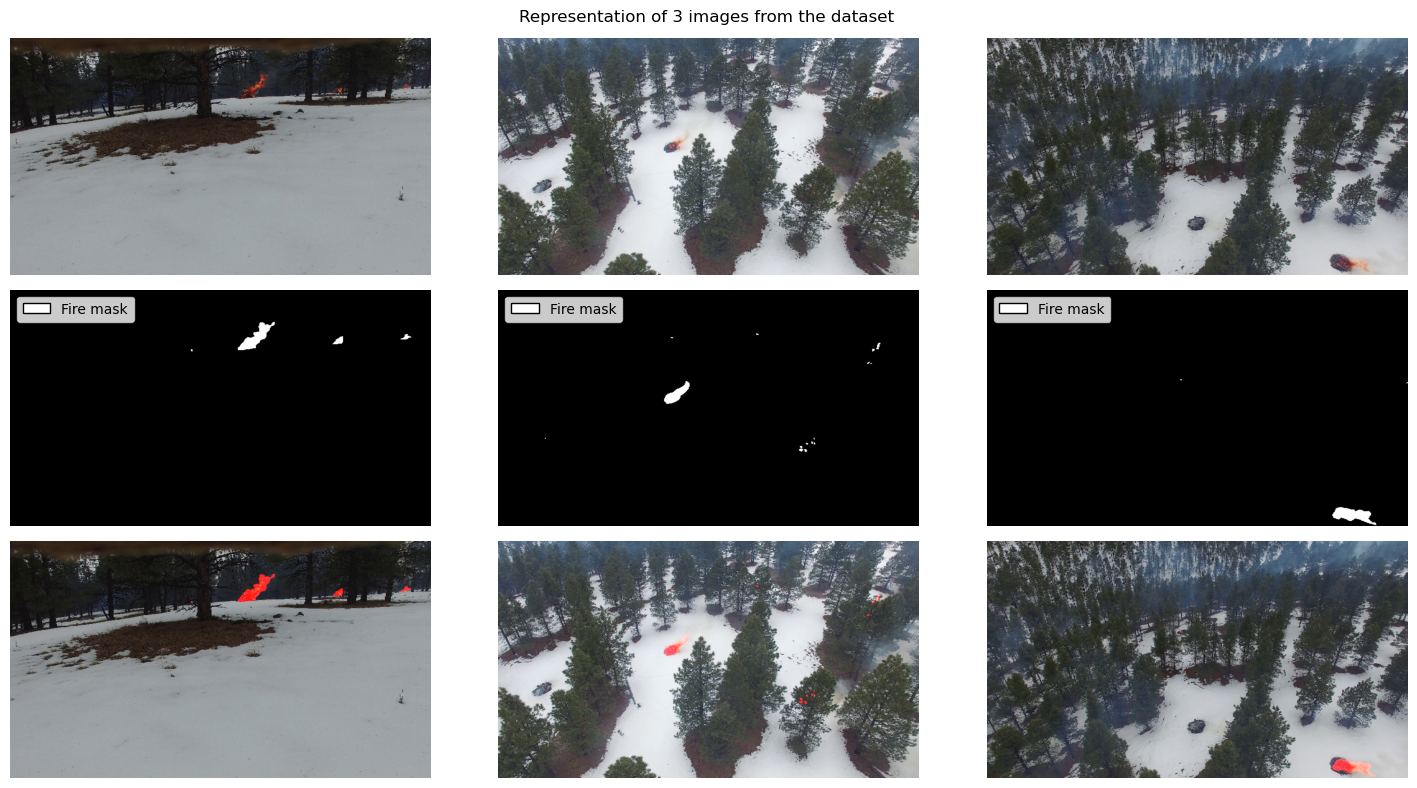

In [11]:
ColorChannel = Union['blue', 'green', 'red']

def get_highlighted_roi_by_mask(
    image: np.ndarray, mask: np.ndarray,
    highlight_channel: Optional[ColorChannel] = 'green'
    ) -> np.ndarray:
    """
    Function that highlights a Region of Interest provided by a mask over an
    image with a given BGR colour.

    Parameters
    ----------
    image: ndarray
        Image on which the mask is highlighted.
    mask: ndarray
        Mask illustrating the Region of Interest to highlight over the
        image.
    highlight_channel: str, optional
        Colour of the highlighted mask: 'blue'; 'green' or 'red', by 
        default: 'green'.

    Returns
    -------
    highlighted_roi: ndarray
        Highlighted Region of Interest over the input image.
    """
    channel_map = { 'blue': 0, 'green': 1, 'red': 2 }

    # Turn the mask into a BGR image.
    mask = mask.astype(np.uint8)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # Force the bits of every channel except the selected one at 0.
    for c, v in channel_map.items():
        if c != highlight_channel:
            mask[..., v] = 0

    mask[mask == 1.] = 255
    # Highlight the unmasked ROI.
    return cv2.addWeighted(mask, 0.9, image, 1, 0)

def resize_images(
    images: np.ndarray, resize_shape: Tuple[int, int]) -> np.ndarray:
    """Resize an array of images to a desired shape.

    Parameters
    ----------
    images : ndarray
        The array of images to reshape
    resize_shape : (int, int)
        The desired output shape of the images.

    Returns
    -------
    ndarray
        The reshaped input array of images.
    """
    images = [cv2.resize(img, resize_shape, interpolation=cv2.INTER_NEAREST)
              for img in images]

    return np.array(images)

def plot_dataset_samples(images: np.ndarray, masks: np.ndarray,
                         num_samples: int = 3, 
                         title: Optional[str] = None,
                         resize_shape: Optional[Tuple[int, int]] = None
                         ) -> None:
    """
    Plot a desired number of dataset samples.
    On the first row the original images are plotted, on the second
    row their masks are shown and on the third one the ROI of
    the fire is highlighted over the image.
    The samples are fetched in a way that their indices are equidistant
    from one to the other in the original array.

    Parameters
    ----------
    images : ndarray
        Numpy array of input images.
    masks : np.ndarray
        Numpy array of the segmentation masks of the given images.
    num_samples : int, optional
        The number of samples to plot, by default 3.
    title : str, optional
        The title of the plot. If not provided it is assigned
        manually. By default None.
    resize_shape : (int, int), optional
        The size used to reshape images before plotting.
        By default None.
    """
    len_images = min(len(images), len(masks))

    # Get equidistant sample indices for the images in the dataset.
    sample_indices = np.linspace(0, len_images - 1, num=num_samples,
                                 dtype=int)
    _, axes = plt.subplots(3, num_samples, figsize=(15, 8))

    images = images[sample_indices]
    masks = masks[sample_indices]
    
    if resize_shape is not None:
        images = resize_images(images, resize_shape)
        masks = resize_images(masks, resize_shape)

    for i, (img, mask) in enumerate(zip(images, masks)):
        # Plot color image.
        ax = axes[0, i]
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')

        # Plot mask.
        ax = axes[1, i]
        ax.imshow(mask, cmap='gray', vmin=0., vmax=1.)
        ax.axis('off')
        legend_elements = [
            Patch(facecolor='w', edgecolor='black',label='Fire mask')]
        ax.legend(handles=legend_elements, loc='upper left')

        # Plot highlighted mask over the color image.
        ax = axes[2, i]
        highlighted_roi = get_highlighted_roi_by_mask(
            img, mask, highlight_channel='red')
        ax.imshow(cv2.cvtColor(highlighted_roi, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        legend_elements = [
            Patch(facecolor='r', edgecolor='black', label='Fire ROI')]
        #ax.legend(handles=legend_elements, loc='upper left')
    if title is None:
        title = f'Representation of {num_samples} images from the dataset '
        'along with their fire mask and the highlighted segmentation'
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_dataset_samples(images, masks, resize_shape=ORIGINAL_SHAPE)

## Data split

According to the original paper, the dataset is split considering as test data the $15\%$ of the whole dataset.

The rest of the data is used for the training procedure, specifically  $85\%$ of it for training the network and  $15\%$ for validating the results. 

The data is shuffled while splitting according to the original seed, considering each instance indipendent to the other.

In [12]:
def get_train_val_test_dataset_split(
    images: np.ndarray, masks: np.ndarray, test_size: float = .15,
    val_size: float = .15, seed: int = 42
    ) -> Tuple[Tuple[np.ndarray, np.ndarray],
               Tuple[np.ndarray, np.ndarray],
               Tuple[np.ndarray, np.ndarray]]:
    """Split the images and mask dataset into train, validation and test.

    Parameters
    ----------
    images : ndarray
        The images of the dataset.
    masks : ndarray
        The segmentation masks of the dataset.
    test_size : float, optional
        The test size ratio, by default 0.15.
    val_size : float, optional
        The validation size ratio, by default 0.15.
    seed : int, optional
        The seed to use for the split, by default 42.

    Returns
    -------
    (ndarray, ndarray)
        Tuple containing the input images and the segmentation masks
        of the train set.
    (ndarray, ndarray)
        Tuple containing the input images and the segmentation masks
        of the validation set.
    (ndarray, ndarray)
        Tuple containing the input images and the segmentation masks
        of the test set.
    """
    X_train, X_test, y_train, y_test =  train_test_split(
        images, masks, test_size=test_size, shuffle=True, random_state=seed)
    X_train, X_val, y_train, y_val =  train_test_split(
        X_train, y_train, test_size=val_size, shuffle=True, random_state=seed)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = \
    get_train_val_test_dataset_split(images, masks, seed=SEED)

In [13]:
print(f'Train shapes: {X_train.shape}, {y_train.shape}')
print(f'Validation shapes: {X_val.shape}, {y_val.shape}')
print(f'Test shapes: {X_test.shape}, {y_test.shape}')

Train shapes: (1446, 512, 512, 3), (1446, 512, 512)
Validation shapes: (256, 512, 512, 3), (256, 512, 512)
Test shapes: (301, 512, 512, 3), (301, 512, 512)


# Modified ERFNet Model

The network is a modification of the *ERFNet* model which is a model for segmantic segmentation composed of an encoder and a decoder. The encoder extracts features from the input image, and the decoder upsamples the features to the original image size. The applied modifications serve to improve the speed of the segmentation process, in order to guarantee its usage for real-time applications. In particular this implementation refears to the semantic segmentation of aerial images captured by drone of woodland fire.

<div align="center">

  ![](https://github.com/schiefen12/fireseg_research/blob/main/Images/Modified-ERFNet-Diagram.png?raw=1)

</div>

## Encoder

The encoder is composed of a sequence of *Downsampler* blocks and *Non-bt-1D* blocks to downsize the image and extract the relevent information.

The *Downsampler* blocks consist of a single 3x3 convolution with a stride of 2 and a Max-Pooling module. The outputs from those functions are then concatenated and batch normalization and the ReLU acivation function are applied.

The *Non-bt-1D* blocks used in the original *ERFNet* model consist of 2 3x1 convolutions followed by 1x3 convolutions, splitting the standard 3x3 convolutions normally used in the non-bottleneck design into 2 1D convolutions. The second pair of 3x1 and 1x3 convolutions are replaced with dilated convolutions to gather more context and improve accuracy. In the modified model, to improve on the efficiency and reduce the computational costs further, the 1x3 convolutions are replaced with 1x1 convolutions.

![](https://github.com/schiefen12/fireseg_research/blob/main/Images/Modified-Blocks.png?raw=1)

The result from the Encoder is then fed into the Decoder portion of the network.


## Decoder

The main purpose of the decoder network is to upsample the feature maps from the encoder to match the initial input resolution. It is composed of a sequence of *Upsampler* blocks and *Non-bt-1D* blocks.

The *Upsampler* blocks consist of simple deconvolutional layers with a stride of 2, followed by batch normalization and the ReLU activation function.

In [31]:
from Models.Modified_DeepLabv3 import FireSegmentationModel
from Models.UNet import UNet
from Models.EfficientSeg import EfficientSeg
from Models.ERFNet import ERFNet
from Models.Modified_ERFNet import ERFNet2

#model = UNet(num_classes=2)
#model = EfficientSeg(dec_config = None, num_classes=2, width_coeff=1.5)
#model = FireSegmentationModel(RESIZE_SHAPE, DEVICE)
#model = ERFNet(num_classes=2)
model = ERFNet2(num_classes=2)

In [32]:
# Set the batch size used for training.
TRAIN_BATCH_SIZE = 2
# Set the batch size used for evaluation.
EVAL_BATCH_SIZE = 2

In [33]:
summary(model, input_size=(TRAIN_BATCH_SIZE, 3, *RESIZE_SHAPE))

Layer (type:depth-idx)                        Output Shape              Param #
ERFNet2                                       [2, 2, 512, 512]          --
├─Encoder: 1-1                                [2, 128, 64, 64]          258
│    └─DownsamplerBlock: 2-1                  [2, 16, 256, 256]         --
│    │    └─Conv2d: 3-1                       [2, 13, 256, 256]         364
│    │    └─MaxPool2d: 3-2                    [2, 3, 256, 256]          --
│    │    └─BatchNorm2d: 3-3                  [2, 16, 256, 256]         32
│    └─ModuleList: 2-2                        --                        --
│    │    └─DownsamplerBlock: 3-4             [2, 64, 128, 128]         7,088
│    │    └─non_bottleneck_1d: 3-5            [2, 64, 128, 128]         9,088
│    │    └─non_bottleneck_1d: 3-6            [2, 64, 128, 128]         9,088
│    │    └─DownsamplerBlock: 3-7             [2, 128, 64, 64]          37,184
│    │    └─non_bottleneck_1d: 3-8            [2, 128, 64, 64]          34,560
│

# Training

## Dataset
The train, validation and test dataloaders are obtained from the previously split train, validation and test images and masks.

The train dataloader uses a dataset where data augmentation is applied  to the retrieved images and masks. In particular, the following operations are applied on both images and masks:
* Their perspective can be randomly distorted by a factor up to $0.3$.
* They can be randomly horizontally flipped.
* A *random affine* tranformation can be finally applied to them composed of a rotation in the range $[-45^{\circ}, +45^{\circ}]$, a translation of fraction $0.1$ of the pixels on the horizontal and vertical axis and a scaling between the factors $[0.5, 1.5]$.

A further transformation is applied to just the images of the train dataloader, which consist in a *color jitter* tranformation which can change the brightness of a factor between $-0.2$ and $0.2$ and the hue of $-0.05$ and $0.05$.

The images of both the train, test and validation dataloaders go all through an additional transformation, which consists in the standard scaling of their values applid to each channel separately. The means of each channel $\mu_B$, $\mu_G$ and $\mu_R$ and their standard deviations $\sigma_B$, $\sigma_G$ and $\sigma_R$ are estimated on the train dataset.

The standardization of a channel $C$ of an image $x$ is computed as:
$$x'_C = \frac{x_C - \mu_C}{\sigma_C}$$

In [34]:
train_mean = np.mean(X_train, axis=(-4, -3, -2))
train_std = np.std(X_train, axis=(-4, -3, -2))

train_mean_std_file_path = os.path.join(BASE_DIR, 'Checkpoints', 'mean-std.npy')
os.makedirs(os.path.dirname(train_mean_std_file_path), exist_ok=True)
np_save(train_mean_std_file_path, (train_mean, train_std))

In [35]:
CHANNELS = ['B', 'G', 'R']

print('Mean of the training images per channel:',
      "; ".join([f'{c}: {m:.2f}' for c, m in zip(CHANNELS, train_mean)]))
print('Standard deviation of the training images per channel:',
      "; ".join([f'{c}: {m:.2f}' for c, m in zip(CHANNELS, train_std)]))

Mean of the training images per channel: B: 121.33; G: 119.34; R: 114.98
Standard deviation of the training images per channel: B: 69.79; G: 66.86; R: 65.85


In [36]:
class FireDetectionDataset(Dataset):
    """Class implementing a dataset for the fire segmentation task.

    Attibutes
    ---------
    X : ndarray
        The input images of the fire segmentation dataset.
    y : ndarray
        The segmentation masks of the input images of the dataset.
    len : int
        The length of the dataset.
    transform_image_and_mask : Compose
        Transform functions composition to apply on both the images
        and masks.
    transform_image : ColorJitter
        Color Jitter transformation to apply solely on the images.
    to_tensor : ToTensor
        Function to transform the images and masks to tensors.
    normalize : Normalize
        Normalization function applied solely on the images.
    """
    def __init__(self, X: np.ndarray, y: np.ndarray, train_mean: np.ndarray,
                 train_std: np.ndarray, apply_augmentation: bool) -> None:
        """Initialize the fire segmentation dataset.

        Parameters
        ----------
        X : ndarray
            The input images of the fire segmentation dataset.
        y : ndarray
            The segmentation masks of the input images of the dataset.
        train_mean : ndarray
            The mean value per channel of the training dataset. It is
            used as an estimation to apply the standard scaling of
            the images for increasing the performances of the model.
        train_std : ndarray
            The standard deviation per channel of the training dataset. It is
            used as an estimation to apply the standard scaling of
            the images for increasing the performances of the model.
        apply_augmentation : bool
            Whether to apply image augmentation while fetching the images
            or not.
        """
        super().__init__()
        assert X.shape[:-1] == y.shape, 'The image does not have the same ' +\
            'shape as the mask.'
        self.X = X
        self.y = y
        self.len = X.shape[0]
        # Set the image and mask transformations if demanded.
        self.transform_image_and_mask = T.Compose([
            T.RandomPerspective(distortion_scale=.3),
            T.RandomHorizontalFlip(),
            T.RandomAffine(degrees=(-45, 45), translate=(0.1, 0.1),
                           scale=(0.5, 1.5))
            ]) if apply_augmentation else None
        # Set the image transformations if demanded.
        self.transform_image = T.ColorJitter(brightness=.2, hue=.05) \
            if apply_augmentation else None
        # Set the tensor transformation.
        self.to_tensor = T.ToTensor()
        # Set the normalization transformation.
        self.normalize = T.Normalize(mean=train_mean, std=train_std)

    def __getitem__(self, index: int
                    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        """
        Get the image and the respective segmentation mask at the
        provided index.
        Data augmentation is applied if demanded.
        The segmentation mask is returned as the background mask
        and the foreground mask defining the fire.

        Parameters
        ----------
        index : int
            The index where the data is fetched.

        Returns
        -------
        FloatTensor
            The image at the given index.
        FloatTensor
            The respective segmentation mask at the given index.
        """
        # Get the data at the given index.
        X, y = self.X[index], self.y[index]

        # Turn the data into a tensor image.
        X = self.to_tensor(X)
        # Turn the mask as a 0/255 value vector for transformation.
        y[y == 1] = 255
        # Turn the mask into a tensor image.
        y = self.to_tensor(y)

        # Apply augmentations to both the image and the mask if demanded.
        if self.transform_image_and_mask is not None:
            # Increase to 3 the number of channels of the mask.
            y = y.expand_as(X)
            # Concatenate the image and the mask.
            X_y = torch.cat([X.unsqueeze(0), y.unsqueeze(0)], dim=0)
            # Apply the same transformations to the image and the mask.
            X_y = self.transform_image_and_mask(X_y)
            # Split the image and the mask.
            X, y = X_y[0], X_y[1]
            # Turn the mask into a 1 channel image.
            y = y[:1]
        # Apply augmentations to the image if demanded.
        if self.transform_image is not None:
            X = self.transform_image(X)
                        
        # Apply standard scaling to the image.
        X = self.normalize(X)

        # Create a background mask that is the opposite of the original
        # fire mask.
        y_b = (~y.bool()).float()
        y = y.bool().float()
        # Create a 2 channel mask containing the semantic segmentation
        # of the background and the foreground.
        y = torch.cat([y_b, y], dim=0)
        return X, y

    def __len__(self) -> int:
        """Get the length of the dataset.

        Returns
        -------
        int
            The length of the dataset.
        """
        return self.len

def get_dataloader(
    X: np.ndarray, y: np.ndarray, train_mean: np.ndarray, 
    train_std: np.ndarray, batch_size: int, shuffle: bool,
    apply_augmentation: bool) -> DataLoader:
    """Get a dataloader for the fire sematic segmentation task.

    Parameters
    ----------
    X : ndarray
        The input images of the fire segmentation dataset.
    y : ndarray
        The segmentation masks of the input images of the dataset.
    train_mean : ndarray
        The mean value per channel of the training dataset. It is
        used as an estimation to apply the standard scaling of
        the images for increasing the performances of the model.
    train_std : ndarray
        The standard deviation per channel of the training dataset. It is
        used as an estimation to apply the standard scaling of
        the images for increasing the performances of the model.
    batch_size : int
        The batch size to use for fetching the images.
    shuffle : bool
        Whether to shuffle the dataset or not before fetching.
    apply_augmentation : bool
        Whether to apply image augmentation while fetching the images
        or not.

    Returns
    -------
    DataLoader
        The dataloader.
    """
    return DataLoader(
        FireDetectionDataset(X, y, train_mean, train_std,
                             apply_augmentation=apply_augmentation),
        batch_size=batch_size, shuffle=shuffle, drop_last=True, num_workers=2)

train_loader = get_dataloader(
    X_train, y_train, train_mean, train_std, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, apply_augmentation=True)

val_loader = get_dataloader(
    X_val, y_val, train_mean, train_std, batch_size=EVAL_BATCH_SIZE,
    shuffle=False, apply_augmentation=False)

test_loader = get_dataloader(
    X_test, y_test, train_mean, train_std, batch_size=EVAL_BATCH_SIZE,
    shuffle=False, apply_augmentation=False)

## Training Utilities

The training utilities and parameters are assigned.
* `Adam` is used as an optimizer with learning rate $1e-4$ and weight decay $1e-5$.
* Two learning rate schedulers are considered.
    * The first is a `StepLR` scheduler that simply decrements the learning rate of the optimizer of a factor $0.94$ after every epoch.
    * The second is a `ReduceLROnPlateau` scheduler that reduces the learning rate step when a plateau is reached. It reduces the learning rate of $0.98$ if the training *loss* does not decrease of a factor $1e-6$ after $300$ batch steps.
* A checkpoint monitor is initialized to control the performances of the model on the validation set, by saving the best resulting weights which consist in the maximal accuracy computed as the sum of the *Mean Pixel Average (MPA)* and the *Mean Intersection over Union (MIoU)*.
* The number of *epochs* is set to $30$.
* Validation is applied every other $200$ batch steps and at the end of every epoch.

In [37]:
#Set the Optimizer
optimizer= torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  
# Set the Learning Rate Schedulers.
step_lr_scheduler = StepLR(optimizer, gamma=.94, step_size=1)
plateau_lr_scheduler = ReduceLROnPlateau(
    optimizer, factor=.98, patience=300, threshold=1e-6)
lr_schedulers=[step_lr_scheduler, plateau_lr_scheduler]

In [38]:
class Checkpoint():
    """Class to handle the checkpoints of a model.

    Attributes
    ----------
    best_accuracy : float
        The best accuracy reached by the model.
    path : str
        The path where the checkpoints are saved.
    """
    def __init__(self, path: str, initial_accuracy: float = 0.) -> None:
        """Initialize the checkpoint instance.
        
        Parameters
        ----------
        path : str
            The checkpoint path.
        initial_accuracy : float, optional
            The initial accuracy value, by default 0.
        """
        # Set the best accuracy as the initial accuracy.
        self.best_accuracy = initial_accuracy

        # Set the checkpoint path.
        self.path = path
        # Create the checkpoint directory if it does not exist.
        os.makedirs(os.path.dirname(self.path), exist_ok=True)

    def save_best(self, model: nn.Module, optimizer: torch.optim.Optimizer,
                  new_accuracy: float) -> None:
        """
        Possibly save the best model weights and optimizer state 
        in the checkpoint file according to the new value of the metric.

        Parameters
        ----------
        model : Module
            The model which weights are saved.
        optimizer : Optimizer
            The optimizer which state is saved
        new_accuracy : float
            The new accuracy value which is compared to the best so far.
            The checkpoints are updated solely if the new accuracy is higher.
        """
        if new_accuracy > self.best_accuracy:
            # Set the new checkpoints.
            checkpoint = {}
            checkpoint['model_state_dict'] = model.state_dict()
            checkpoint['optimizer_state_dict'] = optimizer.state_dict()
            checkpoint['best_accuracy'] = new_accuracy

            # Save the checkpoints.
            torch.save(checkpoint, self.path)
            # Update the best accuracy reached by the model.
            self.best_accuracy = new_accuracy

    def load_best_weights(self, model: nn.Module) -> None:
        """Load the best weights on a model.

        Parameters
        ----------
        model : Module
            The model for which the best weights are loaded.
        """
        # Load the checkpoints and set the model weights.
        checkpoint = torch.load(self.path)
        model.load_state_dict(checkpoint['model_state_dict'])

# Set the number of epochs.
EPOCHS = 30

# Set the validation step.
VAL_STEP = 200

# Set the checkpoint monitor.
checkpoint = Checkpoint(os.path.join(BASE_DIR, 'Checkpoints', 'ModifiedERFNet.pth'))

## Training Loop
The training procedure is performed. The loss criterion is the *Focal Loss* between the logits of the predictions and the ground truth. This criterion is used in order for the model to focus its training on the harder sematic segmentation to obtain, namely the fire itself.

The *Mean Pixel Average (MPA)* and the *Mean Intersection over Union (MIoU)* are tracked as well on both the train and validation sets.

$$MPA = \frac{1}{k + 1}\sum\limits_{i = 0}^k \frac{p_{ii}}{\sum_{j=0}^k p_{ij}}$$

$$MIoU = \frac{1}{k + 1}\sum\limits_{i = 0}^k \frac{p_{ii}}{\sum_{j=0}^k p_{ij} + \sum_{j=0}^k p_{ji} - p_{ii}} $$

where $k$ represents the number of classes ($k = 1$ , including fire and background), and $p_{ij}$ represents the
number of pixels that belong to class $i$ but are predicted to be
class $j$ ; $p_{ii}$ represents the number of pixels that belong to class
$i$ and are correctly predicted as class $i$.

In [39]:
class FocalLoss(nn.Module):
    """
    Focal Loss implementation for the semantic segmentation tasks.

    Attributes
    ----------
    alpha : float
        Balancing parameter for class weights.
    gamma : float
        Focusing parameter to adjust the loss contribution of
        well-classified and misclassified examples.
        
    Methods
    -------
    forward(inputs: FloatTensor, targets: FloatTensor) -> FloatTensor:
        Apply the Focal Loss between the model predictions and
        the ground truth target tensors.
    """
    def __init__(self, alpha: float = 0.25, gamma: float = 2.) -> None:
        """Initialize the Focal Loss module.

        Parameters
        ----------
        alpha : float, optional
            Balancing parameter for class weights, by default 0.25.
        gamma : float, optional
            Focusing parameter to adjust the loss contribution of
            well-classified and misclassified examples. By default 2.
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs: torch.FloatTensor, targets: torch.FloatTensor
                ) -> torch.FloatTensor:
        """Compute the forward pass of the Focal Loss.

        Parameters
        ----------
        inputs : FloatTensor
            Tensor of the model predictions.
        targets : FloatTensor
            Tensor of the ground truth values.

        Returns
        -------
        FloatTensor
            Scalar value of the Focal Loss.
        """
        # Get the cross entropy without reduction.
        cross_entropy_loss = F.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none')

        # Compute the pt value and the focal loss.
        pt = torch.exp(-cross_entropy_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * cross_entropy_loss
        return focal_loss.mean()

class MIoU(nn.Module):
    """
    Mean Intersection over Union (MIoU) implementation for the
    semantic segmentation tasks.

    Attributes
    ----------
    smooth : float
        Smoothing value to avoid division by zero.

    Methods
    -------
    forward(inputs: FloatTensor, targets: FloatTensor) -> FloatTensor:
        Apply the MIoU between the model predictions and
        the ground truth target tensors.
    """
    def __init__(self, smooth: float = 1e-6) -> None:
        """Initialize the MIoU module.

        Parameters
        ----------
        smooth : float, optional
            Smoothing value to avoid division by zero,
            by default 1e-6.
        """
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs: torch.FloatTensor, targets: torch.FloatTensor
                ) -> torch.FloatTensor:
        """Compute the forward pass of the MIoU.

        Parameters
        ----------
        inputs : FloatTensor
            Tensor of the model predictions.
        targets : FloatTensor
            Tensor of the ground truth values.

        Returns
        -------
        FloatTensor
            Scalar value of the MIoU.
        """
        with torch.no_grad():
            # Get the image predictions through softmax and argmax
            # (0: background, 1: foreground).
            inputs = inputs.softmax(-3).argmax(-3, keepdim=True)

            # Concatenate the background and foreground predictions
            # channel-wise.
            bg_predictions = ~inputs.bool()
            fg_predictions = inputs.bool()
            inputs = torch.cat([bg_predictions, fg_predictions], dim=-3)

            # Turn the ground truth to a boolean tensor.
            targets = targets.bool()

            # Get the intersection.
            intersection = (inputs & targets).sum((-2, -1))
            # Get the union.
            union = (inputs | targets).sum((-2, -1))

            # Compute the MIoU.
            iou = (intersection + self.smooth) / (union + self.smooth)
            return torch.mean(iou)

class MPA(nn.Module):
    """
    Mean Pixel Average (MPA) implementation for the semantic
    segmentation tasks.

    Attributes
    ----------
    smooth : float
        Smoothing value to avoid division by zero.

    Methods
    -------
    forward(inputs: FloatTensor, targets: FloatTensor) -> FloatTensor:
        Apply the MPA between the model predictions and
        the ground truth target tensors.
    """
    def __init__(self, smooth: float = 1e-6) -> None:
        """Initialize the MPA module.

        Parameters
        ----------
        smooth : float, optional
            Smoothing value to avoid division by zero,
            by default 1e-6.
        """
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs: torch.FloatTensor, targets: torch.FloatTensor
                ) -> torch.FloatTensor:
        """Compute the forward pass of the MPA.

        Parameters
        ----------
        inputs : FloatTensor
            Tensor of the model predictions.
        targets : FloatTensor
            Tensor of the ground truth values.

        Returns
        -------
        FloatTensor
            Scalar value of the MPA.
        """
        with torch.no_grad():
            # Get the image predictions through softmax and argmax
            # (0: background, 1: foreground).
            inputs = inputs.softmax(-3).argmax(-3, keepdim=True)

            # Concatenate the background and foreground predictions
            # channel-wise.
            bg_predictions = ~inputs.bool()
            fg_predictions = inputs.bool()
            inputs = torch.cat([bg_predictions, fg_predictions], dim=-3)

            # Turn the ground truth to a boolean tensor.
            targets = targets.bool()

            # Get the intersection.
            intersection = (inputs & targets).sum((-2, -1))
            # Get the total number of elements per image (pixel count).
            total_pixels = targets.sum((-2, -1))

            # Compute the MPA.
            mpa = (intersection + self.smooth) / (total_pixels + self.smooth)
            return torch.mean(mpa)
        
def resize_image_batch(images: torch.FloatTensor,
                       new_size: Tuple[int, int]) -> torch.FloatTensor:
    resize = Resize(new_size, InterpolationMode.NEAREST)
    return resize(images)

def validate(
    model: model, val_dataloader: DataLoader, device: str,
    resize_evaluation_shape: Optional[Tuple[int, int]] = None
    ) -> Tuple[float, float, float, float]:
    """
    Validate the predictions of a model for the semantic segmentation
    task of fires. The loss, MPA (Mean Pixel Average), MIoU (Mean
    Intersection over Union) and FPS (Frames Per Second) are computed
    on the results with respect to the ground truth. 

    Parameters
    ----------
    model : FireSegmentationModel
        The model to use for validation.
    val_dataloader : DataLoader
        The data loader used for validation.
    device : str
        The device to use for validation.
    resize_evaluation_shape : (int, int), optional
        The target shape of the segmentation masks to use for
        evaluation. If not provided, the shape remains unchanged.
        By default None.

    Returns
    -------
    float
        The validation loss.
    float
        The validation MPA (Mean Pixel Average).
    float
        The validation MIoU (Mean Intersection over Union).
    float
        The validation FPS (Frames Per Second).
    """
    torch.cuda.empty_cache()
    model.eval()

    criterion = FocalLoss()
    mpa_metric = MPA()
    miou_metric = MIoU()

    running_val_loss = 0.
    running_val_mpa = 0.
    running_val_miou = 0.
    running_val_fps = 0.

    with torch.no_grad():
        
        for _, (x, y) in enumerate(val_dataloader):
            # Put the data to the desired device.
            x = x.to(device=device)
            y = y.to(device=device)

            # Compute the model predictions.
            torch.cuda.synchronize(device)
            start_time = time()
            y_pred = model(x)
            #y_pred = y_pred['out']
            torch.cuda.synchronize(device)
            time_taken = time() - start_time

            if resize_evaluation_shape is not None:
                # Resize the predictions and the ground truth masks.
                y = resize_image_batch(y, new_size=resize_evaluation_shape)
                y_pred = resize_image_batch(
                    y_pred, new_size=resize_evaluation_shape)

            # Compute the loss on the results and ground truth.
            loss = criterion(y_pred, y)
            running_val_loss += loss.item()

            # Compute the accuracies.
            mpa = mpa_metric(y_pred, y)
            miou = miou_metric(y_pred, y)

            # Update the running metrics.
            running_val_mpa += mpa.item()
            running_val_miou += miou.item()
            running_val_fps += x.shape[0] / time_taken

    # Remove unused tensors from gpu memory.
    torch.cuda.empty_cache()

    # Get the average metrics.
    val_loss = running_val_loss / len(val_dataloader)
    val_mpa = running_val_mpa / len(val_dataloader)
    val_miou = running_val_miou / len(val_dataloader)
    fps = running_val_fps / len(val_dataloader)

    return val_loss, val_mpa, val_miou, fps

def train(
    model: model, optimizer: torch.optim.Optimizer,
    train_dataloader: DataLoader, val_dataloader: DataLoader,
    epochs: int, validation_step: int, device: str,
    checkpoint: Optional[Checkpoint] = None, lr_schedulers: List[object] = [],
    reload_best_weights: bool = True) -> Dict[str, np.ndarray]:
    """
    Train a model for the semantic segmentation task of fires.

    Parameters
    ----------
    model : FireSegmentationModel
        The model to train.
    optimizer : Optimizer
        The optimizer used to train the model.
    train_dataloader : DataLoader
        The data loader used for training.
    val_dataloader : DataLoader
        The data loader used for validation.
    epochs : int
        The number of epochs to train the model for.
    validation_steps : int
        The number of steps to wait for applying validation.
    device : str
        The device to use for training.
    checkpoint : Checkpoint, optional
        The checkpoint used to save the best model, by default None.
    lr_schedulers : list of object, optional
        The learning rate schedulers for the optimizer.
        The first element of the list is the learning rate step
        scheduler, while the second is the learning rate scheduler
        that updates the learning rate on plateau, by default empty list.
    reload_best_weights : bool, optional
        Whether to reload the best weights after training, by default True.

    Returns
    -------
    { str: ndarray }
        A dictionary containing the training history.
    """
    # Initialize loss functions.
    criterion = FocalLoss()
    mpa_metric = MPA()
    miou_metric = MIoU()

    # Get the learning rate schedulers.
    step_lr_scheduler = lr_schedulers[0] if len(lr_schedulers) > 0 else None
    plateau_lr_scheduler = lr_schedulers[1] if len(lr_schedulers) > 1 else None

    # Initialize histories.
    metrics = ['train_loss', 'train_mpa', 'train_miou', 'val_loss', 'val_mpa',
               'val_miou']
    history = { m: [] for m in metrics }

    # Set model in training mode.
    model.train()

    # Iterate across the epochs.
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        # Remove unused tensors from gpu memory.
        torch.cuda.empty_cache()

        # Initialize running loss and accuracies.
        running_train_loss = 0.
        running_train_mpa = 0.
        running_train_miou = 0.

        start_time = time()

        for batch_idx, (x, y) in enumerate(train_dataloader):
            # Increment the number of batch steps.
            batch_steps = batch_idx + 1

            # Put the data to the desired device.
            x = x.to(device=device)
            y = y.to(device=device)

            # Compute model predictions.
            y_pred = model(x)

            # Compute the loss on the scaled results and ground truth.
            loss = criterion(y_pred, y)
            running_train_loss += loss.item()

            # Zero the gradients.
            optimizer.zero_grad()

            # Compute accuracies and update the running accuracies.
            mpa = mpa_metric(y_pred, y)
            miou = miou_metric(y_pred, y)

            running_train_mpa += mpa.item()
            running_train_miou += miou.item()

            # Use the loss function for backpropagation.
            loss.backward()

            # Update the weights.
            optimizer.step()

            # Increase the plateau learning rate scheduler step.
            plateau_lr_scheduler.step(running_train_loss / batch_steps)

            epoch_time = time() - start_time
            batch_time = epoch_time / batch_steps

            print(
                f'[{batch_steps}/{len(train_dataloader)}] -',
                f'{epoch_time:.0f}s {batch_time * 1e3:.0f}ms/step -',

                f'train {{ loss: {running_train_loss / batch_steps:.3g} -',
                f'MPA: {running_train_mpa * 100. / batch_steps:.3g}% -',
                f'MiOU: {running_train_miou * 100. / batch_steps:.3g}% }} -',

                f'lr: {optimizer.param_groups[0]["lr"]:.3g}',
                '             ' if batch_steps < len(train_dataloader) else '',
                end='\r')

            # Apply the validation step.
            if batch_steps % validation_step == 0:
                # Set the model in evaluation mode.
                model.eval()

                # Get the validation results.
                val_results = validate(model, val_dataloader, device)
                val_loss, val_mpa, val_miou, _ = val_results

                print(
                    '[VALIDATION] -',
                    f'{epoch_time:.0f}s -',

                    f'val: {{ loss: {val_loss:.3g} -',
                    f'MPA: {val_mpa * 100:.3g}% -',
                    f'MiOU: {val_miou * 100:.3g}% }} -',

                    f'lr: {optimizer.param_groups[0]["lr"]:.3g} -',
                    end='\r'
                )

                # Save the model checkpoints if demanded.
                if checkpoint is not None:
                    accuracy_sum = val_mpa + val_miou
                    checkpoint.save_best(model, optimizer, accuracy_sum)

                # Set model in training mode.
                model.train()

        # Set the model in evaluation mode.
        model.eval()

        # Get train results.
        train_loss = running_train_loss / len(train_dataloader)
        train_mpa = running_train_mpa / len(train_dataloader)
        train_miou = running_train_miou / len(train_dataloader)

        # Get validation results.
        val_results = validate(model, val_dataloader, device)
        val_loss, val_mpa, val_miou, _ = val_results

        # Update the training history.
        history['train_loss'].append(train_loss)
        history['train_mpa'].append(train_mpa)
        history['train_miou'].append(train_miou)

        history['val_loss'].append(val_loss)
        history['val_mpa'].append(val_mpa)
        history['val_miou'].append(val_miou)

        # Save the model checkpoints if demanded.
        if checkpoint is not None:
            accuracy_sum = val_mpa + val_miou
            checkpoint.save_best(model, optimizer, accuracy_sum)

        print(
            f'[{len(train_dataloader)}/{len(train_dataloader)}] -',
            f'{epoch_time:.0f}s -',

            f'train: {{ loss: {train_loss:.3g} -',
            f'MPA: {train_mpa * 100:.3g}% -',
            f'MiOU: {train_miou * 100:.3g}% }} -',

            f'val: {{ loss: {val_loss:.3g} -',
            f'MPA: {val_mpa * 100:.3g}% -',
            f'MiOU: {val_miou * 100:.3g}% }} -',

            f'lr: {optimizer.param_groups[0]["lr"]:.3g}',
            )

        # Increase the learning rate scheduler step.
        step_lr_scheduler.step()

        # Set model in training mode.
        model.train()

    # Load the best model weights if demanded.
    if checkpoint is not None and reload_best_weights:
        checkpoint.load_best_weights(model)

    # Set the model in evaluation mode.
    model.eval()

    # Remove unused tensors from gpu memory.
    torch.cuda.empty_cache()

    # Turn histories in numpy arrays.
    for k, v in history.items():
        history[k] = np.array(v)

    return history
    
history = train(model, optimizer, train_loader, val_loader, EPOCHS, VAL_STEP,
                DEVICE, checkpoint, lr_schedulers, reload_best_weights=True)

Epoch 1/30
[723/723] - 92s - train: { loss: 0.0103 - MPA: 51.8% - MiOU: 49.4% } - val: { loss: 0.00483 - MPA: 50% - MiOU: 49.7% } - lr: 0.0001
Epoch 2/30
[723/723] - 85s - train: { loss: 0.00312 - MPA: 52.4% - MiOU: 50.8% } - val: { loss: 0.00299 - MPA: 50% - MiOU: 49.7% } - lr: 9.4e-05
Epoch 3/30
[723/723] - 95s - train: { loss: 0.00145 - MPA: 53.1% - MiOU: 52.5% } - val: { loss: 0.00225 - MPA: 50% - MiOU: 49.7% } - lr: 8.84e-05
Epoch 4/30
[723/723] - 85s - train: { loss: 0.000939 - MPA: 52.6% - MiOU: 52.4% } - val: { loss: 0.0174 - MPA: 51.2% - MiOU: 50.9% } - lr: 7.98e-05
Epoch 5/30
[723/723] - 85s - train: { loss: 0.000771 - MPA: 53.4% - MiOU: 53.1% } - val: { loss: 0.000873 - MPA: 51.9% - MiOU: 51.6% } - lr: 7.2e-05
Epoch 6/30
[723/723] - 85s - train: { loss: 0.000681 - MPA: 55.1% - MiOU: 54.8% } - val: { loss: 0.000916 - MPA: 56.4% - MiOU: 56% } - lr: 6.5e-05
Epoch 7/30
[723/723] - 87s - train: { loss: 0.000602 - MPA: 59.6% - MiOU: 59% } - val: { loss: 0.00188 - MPA: 61.8% - MiOU

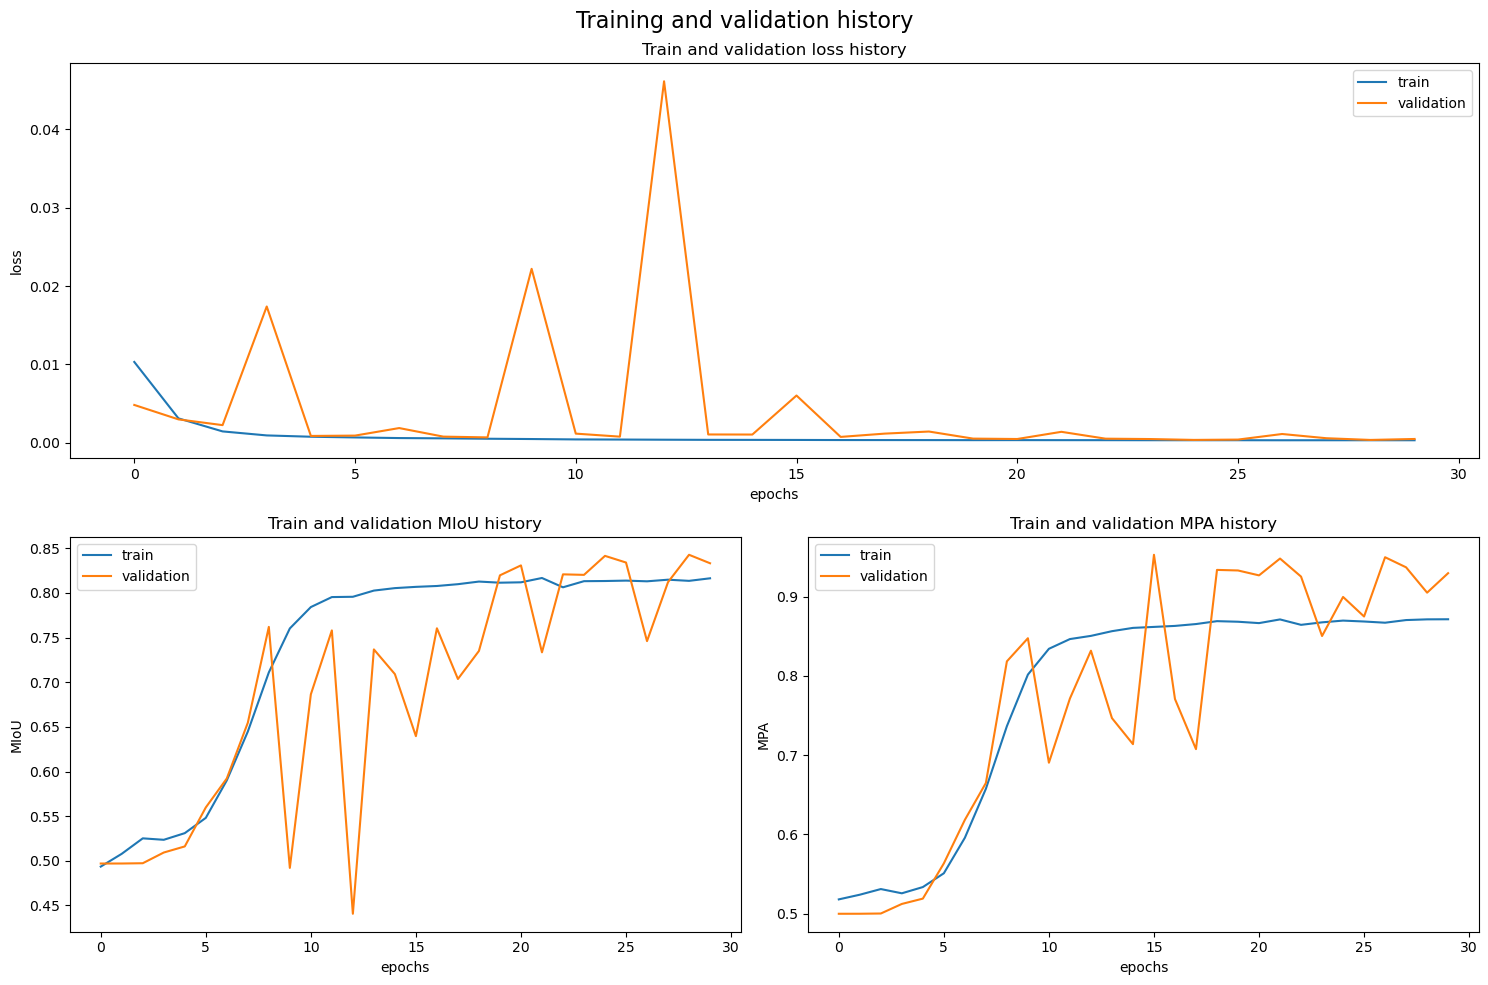

In [40]:
def _plot_subplot(
    index: int, train_history: np.ndarray, val_history: np.ndarray,
    title: str, metric_name: str) -> None:
    """Plot a training history subplot for a specific metric.

    Parameters
    ----------
    index : int
        The subplot index.
    train_history : ndarray
        The training history of a specific metric.
    val_history : ndarray
        The validation history of a specific metric.
    title : str
        The title of the subplot.
    metric_name : str
        The name of the considered metric.
    """
    # Plot the subplot at the given index.
    plt.subplot(*index)
    # Set the title.
    plt.title(title)

    # Plot the training and validation history.
    plt.plot(train_history, label='train')
    plt.plot(val_history, label='validation')

    # Set the x and y labels.
    plt.xlabel('epochs')
    plt.ylabel(metric_name)

    # Plot the legend.
    plt.legend()

def plot_training_history(history: Dict[str, np.ndarray]) -> None:
    """Plot the training history of the model.

    Parameters
    ----------
    history : { str: ndarray }
        A dictionary containing the training history values, including:
        * Train loss history.
        * Validation loss history.
        * Train MIoU (Mean Intersection over Union) history.
        * Validation MIoU history.
        * Train MPA (Mean Pixel Average) history.
        * Validation MPA history.
    """
    plt.figure(figsize=(15, 10))

    # Plot the training history subplots.
    _plot_subplot((2, 1, 1), history['train_loss'], history['val_loss'],
                  'Train and validation loss history', 'loss')
    _plot_subplot((2, 2, 3), history['train_miou'], history['val_miou'],
                  'Train and validation MIoU history', 'MIoU')
    _plot_subplot((2, 2, 4), history['train_mpa'],
                  history['val_mpa'],
                  'Train and validation MPA history', 'MPA')

    # Set the title.
    plt.suptitle('Training and validation history', size=16)

    # Configure the layout and plot.
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Results

In this section, the predictions of the model are evaluated and some samples of the outputed segmentation masks are shown.

In [41]:
checkpoint = Checkpoint(os.path.join(BASE_DIR, 'Checkpoints', 'ModifiedERFNet.pth'))
checkpoint.load_best_weights(model)
model.eval();

## Validation Results

Here are the results on the validation set. The metrics used for evaluation are MPA, MIoU and FPS.

In [42]:
# Get the validation evaluation results.
val_loss, val_mpa, val_miou, val_fps = validate(
    model, val_loader, DEVICE, resize_evaluation_shape=ORIGINAL_SHAPE)

In [43]:
print('Validation loss:', f'{val_loss:.3g}')
print('Validation MPA:', f'{val_mpa * 100:.3g}')
print('Validation MIoU:', f'{val_miou * 100:.3g}')
print('Validation FPS:', f'{val_fps:.3g}')

Validation loss: 0.000458
Validation MPA: 93.6
Validation MIoU: 83.3
Validation FPS: 101


## Test Results

The results of the model are evaluated on the test set and the metrics used for evaluation are once again MPA, MIoU and FPS.

In [44]:
# Get the test evaluation results.
test_loss, test_mpa, test_miou, test_fps = validate(
    model, test_loader, DEVICE, resize_evaluation_shape=ORIGINAL_SHAPE)

In [45]:
print('Test loss:', f'{test_loss:.3g}')
print('Test MPA:', f'{test_mpa * 100:.3g}')
print('Test MIoU:', f'{test_miou * 100:.3g}')
print('Test FPS:', f'{test_fps:.3g}')

Test loss: 0.000458
Test MPA: 93
Test MIoU: 82.4
Test FPS: 101


## Qualitative Analysis

In [46]:
def predict(
    model: model, dataloader: DataLoader, device: str
    ) -> np.ndarray:
    """
    Get the predicted segmentation mask from the data of a
    dataloader.

    Parameters
    ----------
    model : FireSegmentationModel
        The model to use for the predictions.
    dataloader : DataLoader
        The data loader which data should be predicted.
    device : str
        The device to use for predicting.

    Returns
    -------
    ndarray
        The predicted and eventually reshaped sematic segmentation
        masks of the images of the dataloader.
    """
    # Remove unused tensors from the GPU.
    torch.cuda.empty_cache()

    # Set the model in evaluation mode.
    model.eval()

    # Set the results array.
    results = []

    with torch.no_grad():
        for _, (x, _) in enumerate(dataloader):
            # Put the data to the desired device.
            x = x.to(device=device)

            # Compute the model predictions.
            y_pred = model(x)
            #y_pred = y_pred['out']
            y_pred = y_pred.softmax(-3).argmax(-3)

            results.extend(y_pred.cpu().numpy())

    # Remove unused tensors from gpu memory.
    torch.cuda.empty_cache()

    return np.array(results)

model.to(DEVICE)
# Get the model test predictions to the original size.
y_pred = predict(model, test_loader, DEVICE)

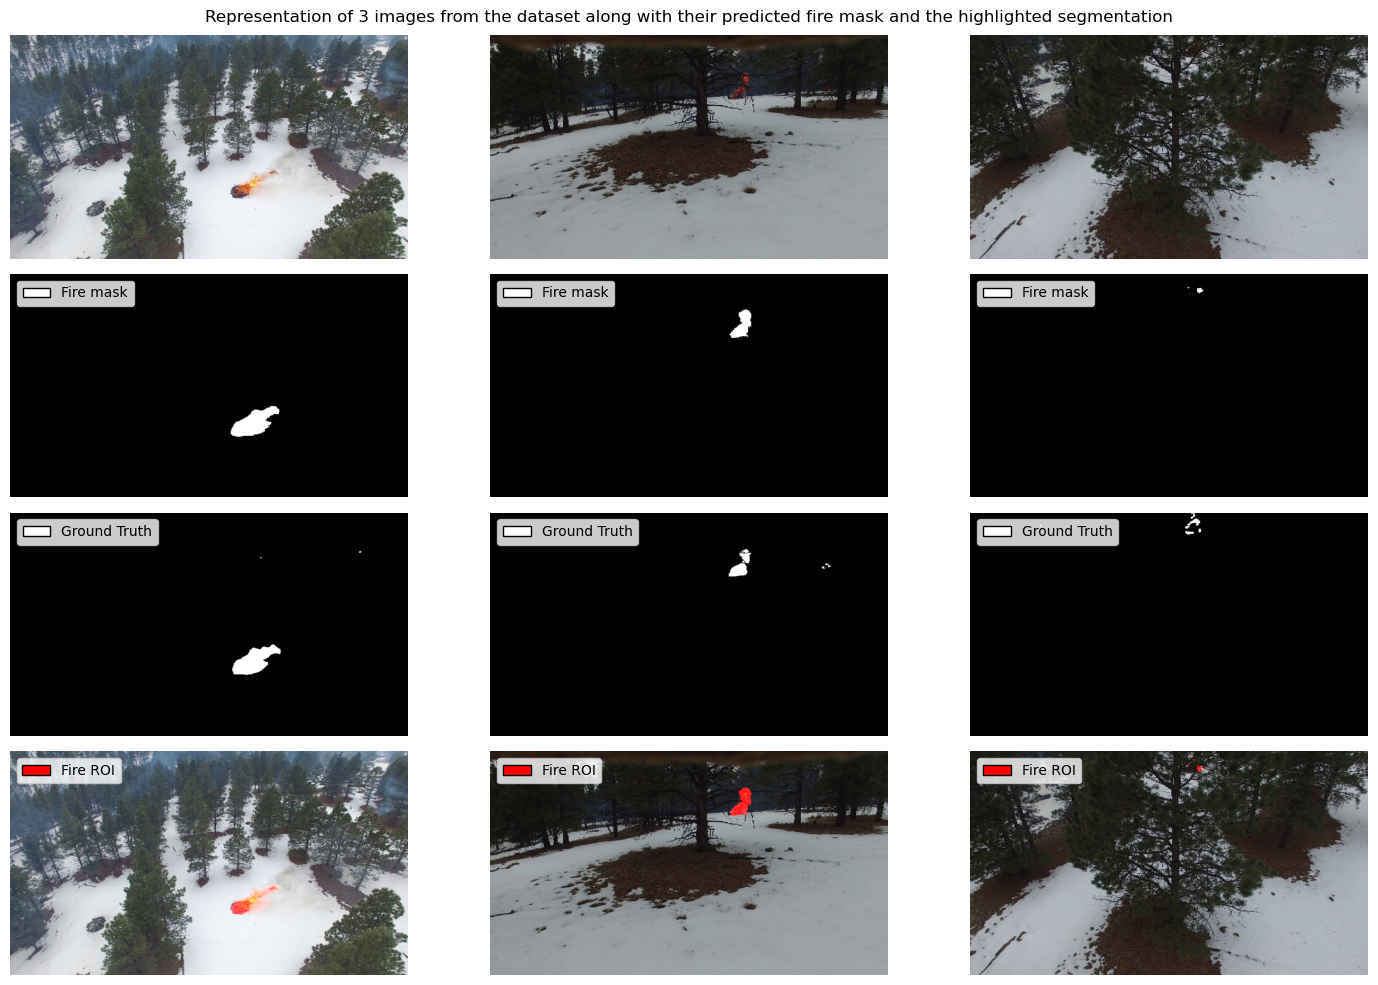

In [47]:
def plot_dataset_predictions(images: np.ndarray, masks: np.ndarray,
                         gt_masks: np.ndarray,
                         num_samples: int = 3, 
                         title: Optional[str] = None,
                         resize_shape: Optional[Tuple[int, int]] = None
                         ) -> None:
    """
    Plot a desired number of dataset samples.
    On the first row, the original images are plotted. On the second
    row, their masks are shown, and on the third one, the ROI of
    the fire is highlighted over the image.
    The samples are fetched in a way that their indices are equidistant
    from one to the other in the original array.

    Parameters
    ----------
    images : ndarray
        Numpy array of input images.
    masks : np.ndarray
        Numpy array of the segmentation masks of the given images.
    gt_masks : np.ndarray
        Numpy array of the ground truth segmentation masks of the given images.
    num_samples : int, optional
        The number of samples to plot, by default 3.
    title : str, optional
        The title of the plot. If not provided, it is assigned
        manually. By default None.
    resize_shape : (int, int), optional
        The size used to reshape images before plotting.
        By default None.
    """
    len_images = min(len(images), len(masks), len(gt_masks))

    # Get equidistant sample indices for the images in the dataset.
    sample_indices = np.linspace(0, len_images - 1, num=num_samples,
                                 dtype=int)
    _, axes = plt.subplots(4, num_samples, figsize=(15, 10))

    images = images[sample_indices]
    masks = masks[sample_indices]
    gt_masks = gt_masks[sample_indices]
    
    if resize_shape is not None:
        images = resize_images(images, resize_shape)
        masks = resize_images(masks, resize_shape)
        gt_masks = resize_images(gt_masks, resize_shape)

    for i, (img, mask, gt_mask) in enumerate(zip(images, masks, gt_masks)):
        # Plot color image.
        ax = axes[0, i]
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')

        # Plot mask.
        ax = axes[1, i]
        ax.imshow(mask, cmap='gray', vmin=0., vmax=1.)
        ax.axis('off')
        legend_elements = [
            Patch(facecolor='w', edgecolor='black', label='Fire mask')]
        ax.legend(handles=legend_elements, loc='upper left')

        # Plot ground truth mask.
        ax = axes[2, i]
        ax.imshow(gt_mask, cmap='gray', vmin=0., vmax=1.)
        ax.axis('off')
        legend_elements = [
            Patch(facecolor='w', edgecolor='black', label='Ground Truth')]
        ax.legend(handles=legend_elements, loc='upper left')

        # Plot highlighted mask over the color image.
        ax = axes[3, i]
        highlighted_roi = get_highlighted_roi_by_mask(
            img, mask, highlight_channel='red')
        ax.imshow(cv2.cvtColor(highlighted_roi, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        legend_elements = [
            Patch(facecolor='r', edgecolor='black', label='Fire ROI')]
        ax.legend(handles=legend_elements, loc='upper left')

    if title is None:
        title = f'Representation of {num_samples} images from the dataset '
        'along with their fire mask, ground truth mask, and the highlighted segmentation'
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_dataset_predictions(
    X_test, y_pred, y_test,
    title='Representation of 3 images from the dataset '
    'along with their predicted fire mask and the highlighted segmentation',
    resize_shape=ORIGINAL_SHAPE)

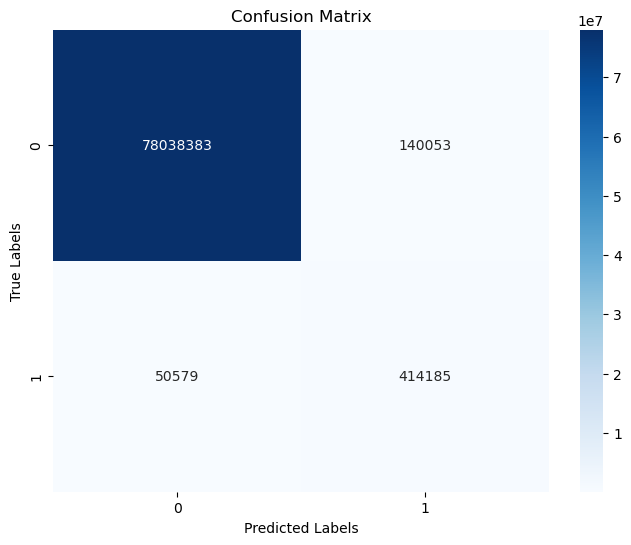

In [48]:
model.to(DEVICE)

#Adjusted prediction function to also compute true labels
def predict(
    model: model, dataloader: DataLoader, device: str
) -> Tuple[np.ndarray, np.ndarray]:
    # Remove unused tensors from the GPU.
    torch.cuda.empty_cache()

    # Set the model in evaluation mode.
    model.eval()

    # Set the results array for predictions and ground truth labels.
    results_pred = []
    results_true = []

    with torch.no_grad():
        for _, (x, y_true) in enumerate(dataloader):
            # Put the data to the desired device.
            x = x.to(device=device)

            # Compute the model predictions.
            y_pred = model(x)
            y_pred = y_pred.softmax(-3).argmax(-3)

            results_pred.extend(y_pred.cpu().numpy())
            results_true.extend(y_true.cpu().numpy())

    # Remove unused tensors from gpu memory.
    torch.cuda.empty_cache()

    return np.array(results_pred), np.array(results_true)


# Get the model test predictions and ground truth labels to the original size.
y_pred, y_true = predict(model, test_loader, DEVICE)

y_true = y_true.argmax(axis=1)

y_pred_flatten = y_pred.flatten()
y_true_flatten = y_true.flatten()    

# Compute the confusion matrix.
conf_matrix = confusion_matrix(y_true_flatten, y_pred_flatten)

# Plot the confusion matrix using seaborn.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()